## Imports

In [1]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


### Loading data

In [2]:
train=pd.read_csv('../input/Kannada-MNIST/train.csv')
test=pd.read_csv('../input/Kannada-MNIST/test.csv')
sample_sub=pd.read_csv('../input/Kannada-MNIST/sample_submission.csv')

### Understanding the data <a id="1" ></a>

In [3]:
print('The Train  dataset has {} rows and {} columns'.format(train.shape[0],train.shape[1]))
print('The Test  dataset has {} rows and {} columns'.format(test.shape[0],test.shape[1]))


The Train  dataset has 60000 rows and 785 columns
The Test  dataset has 5000 rows and 785 columns


In [4]:
train.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head(3)
test=test.drop('id',axis=1)


### Checking Target class distribution..


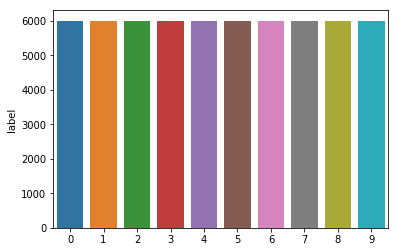

In [6]:
y=train.label.value_counts()
sns.barplot(y.index,y)

## Data preparation <a id='2'></a>

In [7]:
X_train=train.drop('label',axis=1)
Y_train=train.label

In [8]:
X_train=X_train/255
test=test/255

### Reshape

In [9]:
X_train=X_train.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

In [10]:
print('The shape of train set now is',X_train.shape)
print('The shape of test set now is',test.shape)


The shape of train set now is (60000, 28, 28, 1)
The shape of test set now is (5000, 28, 28, 1)


### Encoding Target Values

In [11]:
Y_train=to_categorical(Y_train)

### Splitting train and test

In [12]:
X_train,X_test,y_train,y_test=train_test_split(X_train,Y_train,random_state=42,test_size=0.15)

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)


## Modelling <a id='4' ></a>

In [14]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(momentum=.15))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(momentum=0.15))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization(momentum=.15))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(10, activation = "softmax"))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)       

In [16]:
optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

In [17]:
model.compile(optimizer=optimizer,loss=['categorical_crossentropy'],metrics=['accuracy'])

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

### Fitting our model <a id='5'></a>

In [19]:
epochs=50 
batch_size=64

In [20]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
 - 21s - loss: 0.2745 - accuracy: 0.9119 - val_loss: 0.0317 - val_accuracy: 0.9913
Epoch 2/50


/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 17s - loss: 0.0681 - accuracy: 0.9796 - val_loss: 0.0276 - val_accuracy: 0.9919
Epoch 3/50
 - 18s - loss: 0.0538 - accuracy: 0.9847 - val_loss: 0.0307 - val_accuracy: 0.9923
Epoch 4/50
 - 17s - loss: 0.0457 - accuracy: 0.9868 - val_loss: 0.0197 - val_accuracy: 0.9939
Epoch 5/50
 - 17s - loss: 0.0405 - accuracy: 0.9885 - val_loss: 0.0209 - val_accuracy: 0.9944
Epoch 6/50
 - 17s - loss: 0.0385 - accuracy: 0.9893 - val_loss: 0.0190 - val_accuracy: 0.9953
Epoch 7/50
 - 17s - loss: 0.0328 - accuracy: 0.9903 - val_loss: 0.0193 - val_accuracy: 0.9947
Epoch 8/50
 - 18s - loss: 0.0325 - accuracy: 0.9905 - val_loss: 0.0247 - val_accuracy: 0.9937
Epoch 9/50
 - 19s - loss: 0.0300 - accuracy: 0.9910 - val_loss: 0.0187 - val_accuracy: 0.9953
Epoch 10/50
 - 17s - loss: 0.0294 - accuracy: 0.9915 - val_loss: 0.0131 - val_accuracy: 0.9956
Epoch 11/50
 - 17s - loss: 0.0269 - accuracy: 0.9923 - val_loss: 0.0139 - val_accuracy: 0.9959
Epoch 12/50
 - 17s - loss: 0.0269 - accuracy: 0.9918 - val_loss: 0.01

## Evaluating our approach <a id='6'></a>

Text(0, 0.5, 'accuracy')

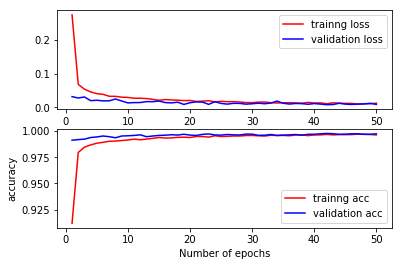

In [21]:
fig,ax=plt.subplots(2,1)
fig.set
x=range(1,1+epochs)
ax[0].plot(x,history.history['loss'],color='red')
ax[0].plot(x,history.history['val_loss'],color='blue')

ax[1].plot(x,history.history['accuracy'],color='red')
ax[1].plot(x,history.history['val_accuracy'],color='blue')
ax[0].legend(['trainng loss','validation loss'])
ax[1].legend(['trainng acc','validation acc'])
plt.xlabel('Number of epochs')
plt.ylabel('accuracy')


In [22]:
y_pre_test=model.predict(X_test)
y_pre_test=np.argmax(y_pre_test,axis=1)
y_test=np.argmax(y_test,axis=1)


In [23]:
conf=confusion_matrix(y_test,y_pre_test)
conf=pd.DataFrame(conf,index=range(0,10),columns=range(0,10))



In [24]:
conf

,0,1,2,3,4,5,6,7,8,9
0,852,6,0,0,0,0,0,0,0,0
1,1,912,0,0,0,0,0,0,0,0
2,1,0,907,0,0,0,0,0,0,0
3,0,0,0,884,0,0,0,6,0,0
4,0,0,0,0,925,0,0,0,0,1
5,0,0,0,0,2,872,0,0,0,0
6,0,0,0,0,0,0,860,1,0,1
7,0,0,0,0,0,0,1,932,0,0
8,0,0,0,0,0,0,0,0,918,0
9,0,0,0,0,0,0,3,0,0,915


In [25]:
test=pd.read_csv('../input/Kannada-MNIST/test.csv')

In [26]:
test_id=test.id

test=test.drop('id',axis=1)
test=test/255
test=test.values.reshape(-1,28,28,1)


In [27]:
test.shape

(5000, 28, 28, 1)

We will make our prediction using our CNN model.

In [28]:
y_pre=model.predict(test)     
y_pre=np.argmax(y_pre,axis=1) 

In [29]:
sample_sub['label']=y_pre
sample_sub.to_csv('submission.csv',index=False)


In [30]:
sample_sub.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7
